## 0. 라이브러리 / 기본셋업

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno

버전 확인

- `python` >= 3.10.12
- `numpy` >= 1.26.0
- `pandas` >= 2.1.1
- `matplotlib` >= 3.8.1
- `seaborn` >= 0.13.0
- `missingno` >= 0.5.2

In [2]:
import sys, matplotlib

print("="*5 ,"나의 라이브러리 버전 확인", "="*5)
print(f"{'python version':15s} <> {sys.version}")
print(f"{'numpy version':15s} <> {np.__version__}")
print(f"{'pandas version':15s} <> {pd.__version__}")
print(f"{'matplotlib version':15s} <> {matplotlib.__version__}")
print(f"{'seaborn version':15s} <> {sns.__version__}")
print(f"{'missingno version':15s} <> {msno.__version__}")

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
numpy version   <> 1.26.0
pandas version  <> 2.1.1
matplotlib version <> 3.8.1
seaborn version <> 0.13.0
missingno version <> 0.5.2


In [3]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

# 데이터 경로 맞춰주세요!
# 혹시 코랩환경을 사용하신다면 왼쪽 폴더모양 아이콘을 눌러 "train_data.csv"를 드래그&드롭으로 업로드한 후 사용해주세요
DATA_PATH = '../../data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

CPU times: user 3.7 s, sys: 540 ms, total: 4.24 s
Wall time: 4.26 s


## 1.1 기본적인 내용 파악

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int16         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int8          
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int16         
dtypes: datetime64[ns](1), int16(2), int8(1), object(2)
memory usage: 62.7+ MB


## 데이터 딕셔너리

| 순번 |      칼럼명      | Non-Null 개수 |     데이터 타입       | 설명 |
|-----|-----------------|--------------|-----------------------|----------------|
|  1  |      userID      |      2266586    | int16                 | 각 학생의 고유 식별자 (총 7,442명의 학생) |
|  2  | assessmentItemID |      2266586    | object                | 사용자가 시도한 문항의 일련 번호 |
|  3  |      testId       |      2266586    | object                | 시도한 문항이 포함된 시험지의 일련 번호 |
|  4  |    answerCode    |      2266586    | int8                  | 사용자가 문항에 대한 정답 여부를 나타내는 이진 데이터 (1: 정답, 0: 오답) |
|  5  |    Timestamp      |      2266586    | datetime64[ns]        | 사용자가 문항을 시도한 시간 정보 |
|  6  |   KnowledgeTag    |      2266586    | int16                 | 문항의 지식 태그 (고유 식별자) |



### 특성의 기본 정보

In [5]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df.answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 6698
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


## TestId, userID별로 그룹화

In [6]:
# 각 testId별로 첫 번째 문항과 마지막 문항을 시도한 시간을 계산
test_times = df.groupby(['testId', 'userID']).agg(first_attempt=('Timestamp', 'min'), last_attempt=('Timestamp', 'max'))

# total_test_time 칼럼 추가 및 초 단위로 변환
test_times['total_test_time'] = (test_times['last_attempt'] - test_times['first_attempt']).dt.total_seconds().astype(int)

test_times.reset_index(inplace=True)


print(test_times)

            testId  userID       first_attempt        last_attempt  \
0       A010000001       8 2020-03-01 08:36:27 2020-03-01 08:39:17   
1       A010000001      14 2020-07-10 08:58:07 2020-07-10 08:59:33   
2       A010000001      16 2020-03-12 21:46:25 2020-03-12 21:48:15   
3       A010000001      18 2020-07-14 12:37:21 2020-07-14 12:38:25   
4       A010000001      46 2020-03-18 02:01:40 2020-03-18 02:03:11   
...            ...     ...                 ...                 ...   
365159  A090000074    3006 2020-12-10 22:24:30 2020-12-10 22:26:34   
365160  A090000074    3023 2020-12-09 19:44:17 2020-12-09 19:44:40   
365161  A090000074    3192 2020-11-03 05:25:50 2020-11-03 05:27:56   
365162  A090000074    3260 2020-12-17 05:18:33 2020-12-17 05:32:29   
365163  A090000074    3445 2020-11-19 18:31:03 2020-11-19 18:32:17   

        total_test_time  
0                   170  
1                    86  
2                   110  
3                    64  
4                    91  
...

### Viloin Plot

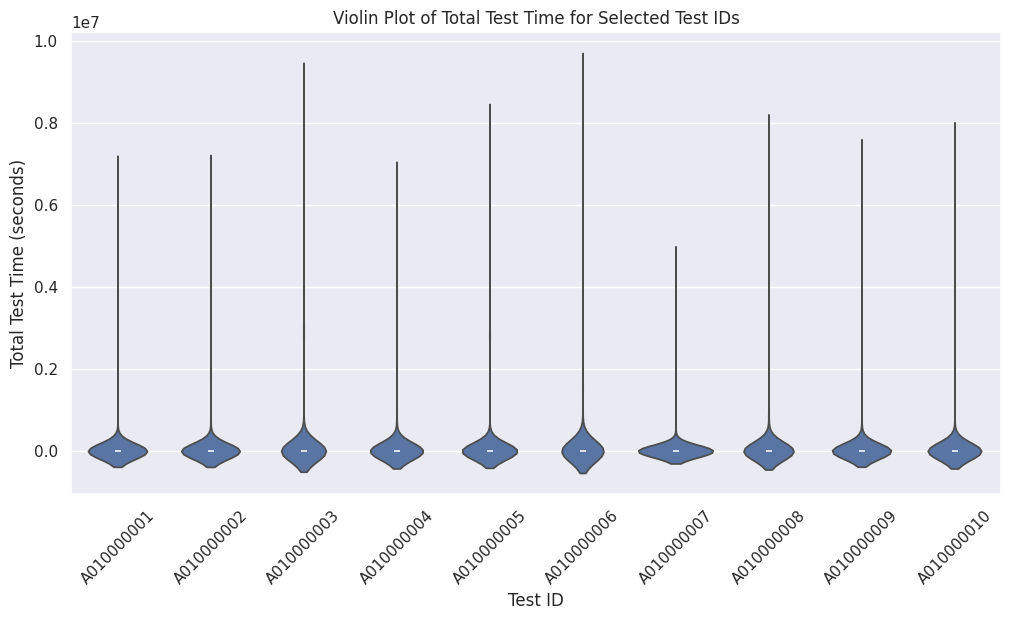

In [7]:
selected_testIds = test_times['testId'].unique()[:10]

selected_data = test_times[test_times['testId'].isin(selected_testIds)]

plt.figure(figsize=(12, 6))
sns.violinplot(x=selected_data['testId'], y=selected_data['total_test_time'])
plt.xlabel('Test ID')
plt.ylabel('Total Test Time (seconds)')
plt.title('Violin Plot of Total Test Time for Selected Test IDs')
plt.xticks(rotation=45)
plt.show()

### Box Plot

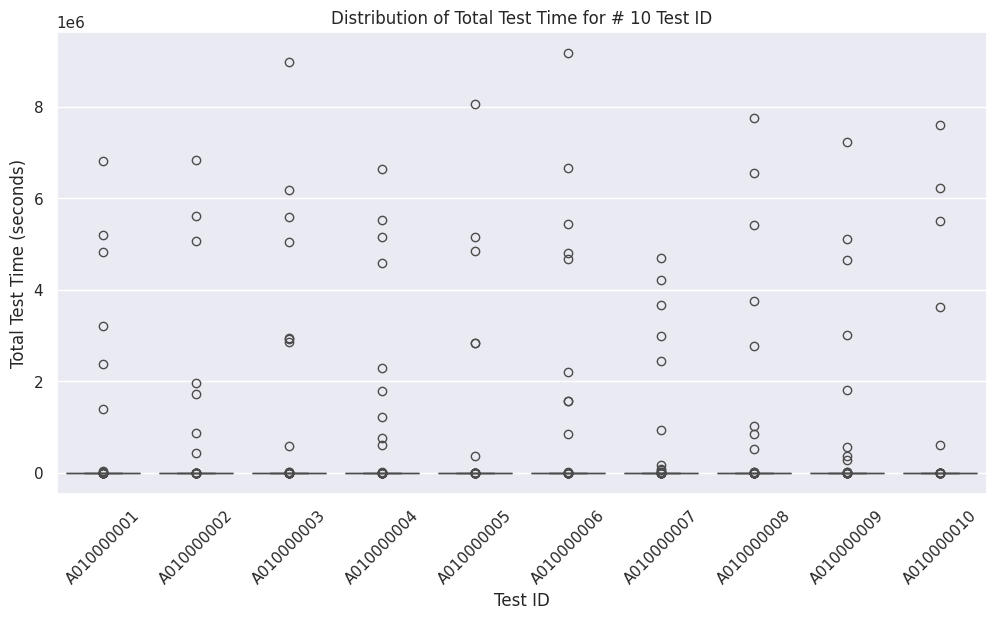

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='testId', y='total_test_time', data=selected_data)
plt.xlabel('Test ID')
plt.ylabel('Total Test Time (seconds)')
plt.title('Distribution of Total Test Time for # 10 Test ID')
plt.xticks(rotation=45)
plt.show()

### 통계치 확인

In [15]:
test_stats = test_times.groupby('testId')['total_test_time'].describe()

print(test_stats)

            count           mean            std   min   25%    50%     75%  \
testId                                                                       
A010000001  311.0   77000.450161  603474.869784  21.0  82.0  115.0  164.50   
A010000002  303.0   74560.798680  603905.618370  14.0  72.5   97.0  162.00   
A010000003  314.0  112154.066879  794089.971305   9.0  78.0  119.0  184.75   
A010000004  299.0   95841.374582  661038.723100  28.0  65.0   90.0  142.00   
A010000005  313.0   77277.693291  644198.768406  15.0  89.0  117.0  175.00   
...           ...            ...            ...   ...   ...    ...     ...   
A090000070   43.0     404.116279     721.844569   8.0  21.0   32.0  426.50   
A090000071   45.0   11077.888889   62370.248234  10.0  21.0   40.0  595.00   
A090000072   45.0     331.555556     750.667387   6.0  15.0   98.0  278.00   
A090000073   45.0    4654.600000   30056.858504   8.0  24.0   87.0  151.00   
A090000074   45.0     225.111111     335.603474   9.0  20.0   97

## 4IQR 기준 이상치 판단

In [25]:
import pandas as pd

outliers = []
u_outliers = []
l_outliers = []

outliers_user = set()

for testId, group in test_times.groupby('testId'):
    q1 = group['total_test_time'].quantile(0.25)
    q3 = group['total_test_time'].quantile(0.75)
    iqr = q3 - q1
    lower_outliers = group['total_test_time'] < (q1 - 1.5 * iqr)
    upper_outliers = group['total_test_time'] > (q3 + 1.5 * iqr)
    test_outliers = (lower_outliers | upper_outliers)
    
    l_outliers.extend(lower_outliers.tolist())
    u_outliers.extend(upper_outliers.tolist())
    outliers.extend(test_outliers.tolist())
    
test_times['outlier'] = outliers
test_times['u_outlier'] = u_outliers
test_times['l_outlier'] = l_outliers
outliers_userIDs = test_times.loc[test_times['outlier'], 'userID'].unique()


print(f"Total Test IDs: {len(test_times['testId'].unique())}")
print(f"Total counts: {len(test_times)}")
print(f"Total outliers counts: {sum(outliers)}")
print(f"Total lower outliers counts: {sum(l_outliers)}")
print(f"Total upper outliers counts: {sum(u_outliers)}")
print(f"Total userIDs: {len(test_times['userID'].unique())}")
print(f"Outlier userIDs: {len(outliers_userIDs)}")


Total Test IDs: 1537
Total counts: 365164
Total outliers counts: 39124
Total lower outliers counts: 0
Total upper outliers counts: 39124
Total userIDs: 6698
Outlier userIDs: 5144
